In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque

In [2]:
def parse_checkpoints(fasta_file):
    nb_unitigs = []
    start_pos = []
    
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                continue
            elif line:
                line = line.split(":", 1)[0]
                line_parts = line.split()
                nb_unitigs.append(int(line_parts[0]))
                start_pos.append(int(line_parts[-1]))
    
    return nb_unitigs, start_pos

def get_repeats(file, max_size_pattern=3, min_nb_patterns=3):
    is_repeat = []
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            # Initialize the deque and repeat counts when a new header is found
            if line.startswith('>'):
                nb_patterns = [0 for _ in range(max_size_pattern)]
                line_history = deque(maxlen=max_size_pattern)
            elif line:
                is_repeat.append(False)
                _, line_nodes = line.split(":", 1)
                for size in range(1, max_size_pattern+1):
                    # If the current line matches a previous one: increase pattern count
                    if len(line_history) >= size and line_nodes == line_history[-size]:
                        nb_patterns[size-1] += 1
                    else:
                        # if pattern was repeated enough times, mark concerned lines as repeat
                        if size+nb_patterns[size-1] >= size*min_nb_patterns:
                            for i in range(size+nb_patterns[size-1]):
                                is_repeat[-(i+1)] = True
                            nb_patterns = [0 for _ in range(max_size_pattern)]
                            break
                        nb_patterns[size-1] = 0
                line_history.append(line_nodes)
    return is_repeat

In [3]:
path_hap_1 = "output/chr1/checkpoints_AalbF5_in_1.fna"
path_hap_2 = "output/chr1/checkpoints_AalbF5_in_2.fna"

nb_unitigs_1_hap, start_pos_1_hap = parse_checkpoints(path_hap_1)
nb_unitigs_2_hap, start_pos_2_hap = parse_checkpoints(path_hap_2)

repeats_1 = get_repeats(path_hap_1, max_size_pattern=3, min_nb_patterns=3)
repeats_2 = get_repeats(path_hap_2, max_size_pattern=3, min_nb_patterns=3)

In [4]:
path_stats_1 = "output/chr1/stats_checkpoints_AalbF5_in_1.fna"
path_stats_2 = "output/chr1/stats_checkpoints_AalbF5_in_2.fna"

df_1 = pd.read_csv(path_stats_1, sep='\t', header=None, comment='>', names=['unitigs', 'breakpoints_left', 'breakpoints_right'])
df_2 = pd.read_csv(path_stats_2, sep='\t', header=None, comment='>', names=['unitigs', 'breakpoints_left', 'breakpoints_right'])

In [5]:
df_1['is_repeat'] = repeats_1
df_1['start_pos'] = start_pos_1_hap

df_2['is_repeat'] = repeats_2
df_2['start_pos'] = start_pos_2_hap

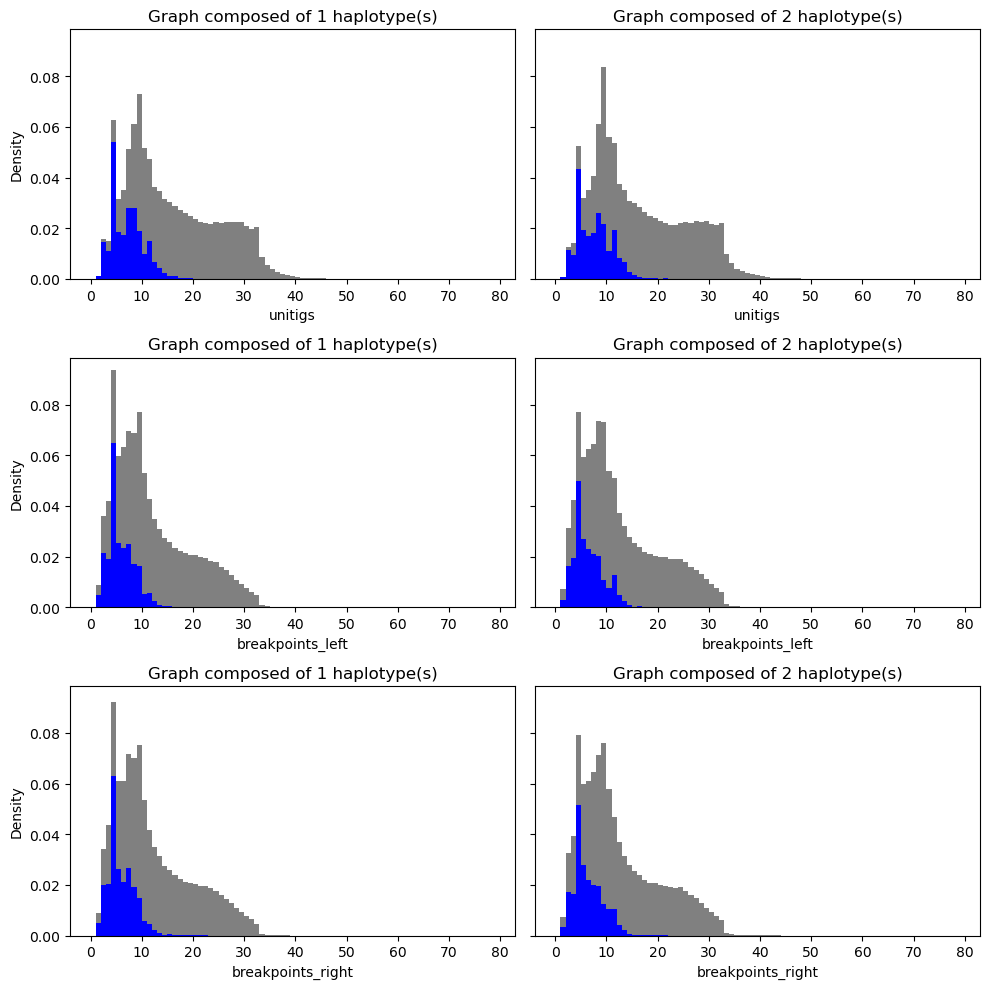

In [6]:
bins = np.arange(0, 80, 1)

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
dfs = [df_1, df_2]

for i in range(2):
    df = dfs[i]

    for j, column in enumerate(['unitigs', 'breakpoints_left', 'breakpoints_right']):

        repeated = df[df['is_repeat'] == True][column]
        not_repeated = df[df['is_repeat'] == False][column]
        
        axes[j,i].hist([repeated, not_repeated], bins=bins, stacked=True, 
                label=['Repeated', 'Not Repeated'],
                color=['blue', 'grey'], density=True)
        axes[j,i].set_title(f'Graph composed of {i+1} haplotype(s)')
        axes[j,i].set_xlabel(column)
        axes[j,0].set_ylabel('Density')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# graph with 1 haplo
df_1['unitigs'].mean()

np.float64(15.333052192604827)

In [ ]:
# graph with 2 haplo
df_2['unitigs'].mean()

np.float64(15.63696158313586)